### **Decision Trees and Random Forest**

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [2]:
classification = pd.read_csv('https://raw.githubusercontent.com/morn12/tb/main/190%20(1).csv',parse_dates=['Date'])
classification.drop(['Date', 'Hour','SMP','Unnamed: 0'], axis=1, inplace=True)
classification
# האם הסמפי יהיה מעל 190 בהינתן פיצרים מסויימים
# האם ניתן לחזות מתי הסמפי יהיה מעל 190

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,24.47,0,1,0,0,0,0
1,24.30,0,1,0,0,0,0
2,24.17,0,1,0,0,0,0
3,23.99,0,1,0,0,0,0
4,23.93,0,1,0,0,0,0
...,...,...,...,...,...,...,...
30708,12.26,0,0,0,0,0,0
30709,12.27,0,0,0,0,0,0
30710,12.06,0,0,0,0,0,0
30711,12.06,0,0,0,0,0,0


#EDA

In [3]:
counts = classification.SMP_Above_190.value_counts()
percentage = [str(round(i/counts.sum()*100,2)) +'%' for i in counts]
percentage 
counts
#'LIGHTSKYBLUE','PLUM'

0    27588
1     3125
Name: SMP_Above_190, dtype: int64

In [4]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Low SMP', 'High SMP'],
    y=counts,
    marker_color=['ROYALBLUE','LIGHTSKYBLUE'],
    text=percentage,
    textposition='outside',
))
fig.update_layout(
    width=600,
    title='The SMP Level', 
    yaxis_title='Number of cases',
    )
fig.show()

## הפרדת המחלקות 

In [5]:
# Class count
count_class_0, count_class_1 = classification.SMP_Above_190.value_counts()

# Divide by class
df_class_0 = classification[classification['SMP_Above_190'] == 0]
df_class_1 = classification[classification['SMP_Above_190'] == 1]

## Up Sampling & Down Sampling

In [6]:
df_class_1_over = df_class_1.sample((count_class_1 * 3),replace=True) 
df_class_0_under = df_class_0.sample(count_class_1 * 3)

# ניפוח המחלקה הקטנה פי 3, ולאחר מכן לקיחת מחלקה רנדומלית מהמחלקה הגדולה שהיא בגודל
# המחלקה הקטנה החדשה

df_balanced = pd.concat([df_class_0_under, df_class_1_over], axis=0)
print('Random under-sampling:')
print(df_balanced.SMP_Above_190.value_counts())

Random under-sampling:
0    9375
1    9375
Name: SMP_Above_190, dtype: int64


In [7]:
counts = df_balanced.SMP_Above_190.value_counts()
percentage = [str(round(i/counts.sum()*100,2)) +'%' for i in counts]
percentage 
counts

0    9375
1    9375
Name: SMP_Above_190, dtype: int64

In [8]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Low SMP', 'High SMP'],
    y=counts,
    marker_color=['ROYALBLUE','LIGHTSKYBLUE'],
    text=percentage,
    textposition='outside',
))
fig.update_layout(
    width=600,
    title='The SMP Level', 
    yaxis_title='Number of cases',
    )
fig.show()

In [9]:
df_balanced.reset_index(drop=True, inplace= True)

#מודל עצי החלטה

In [10]:
X = df_balanced.drop('SMP_Above_190',axis=1)
y = df_balanced['SMP_Above_190']
X

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW
0,13.36,0,0,0,0,0
1,18.04,0,0,0,0,0
2,16.73,0,0,1,0,0
3,25.04,0,0,0,0,0
4,13.87,1,0,0,0,0
...,...,...,...,...,...,...
18745,26.26,0,1,1,0,1
18746,25.67,1,0,0,0,0
18747,23.03,0,0,0,0,0
18748,30.17,0,1,0,0,0


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [12]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="entropy",max_depth=4) # מקסימום גובה, שלבים של העץ
dtree.fit(X_train,y_train) # אימון של סט האימון

DecisionTreeClassifier(criterion='entropy', max_depth=4)

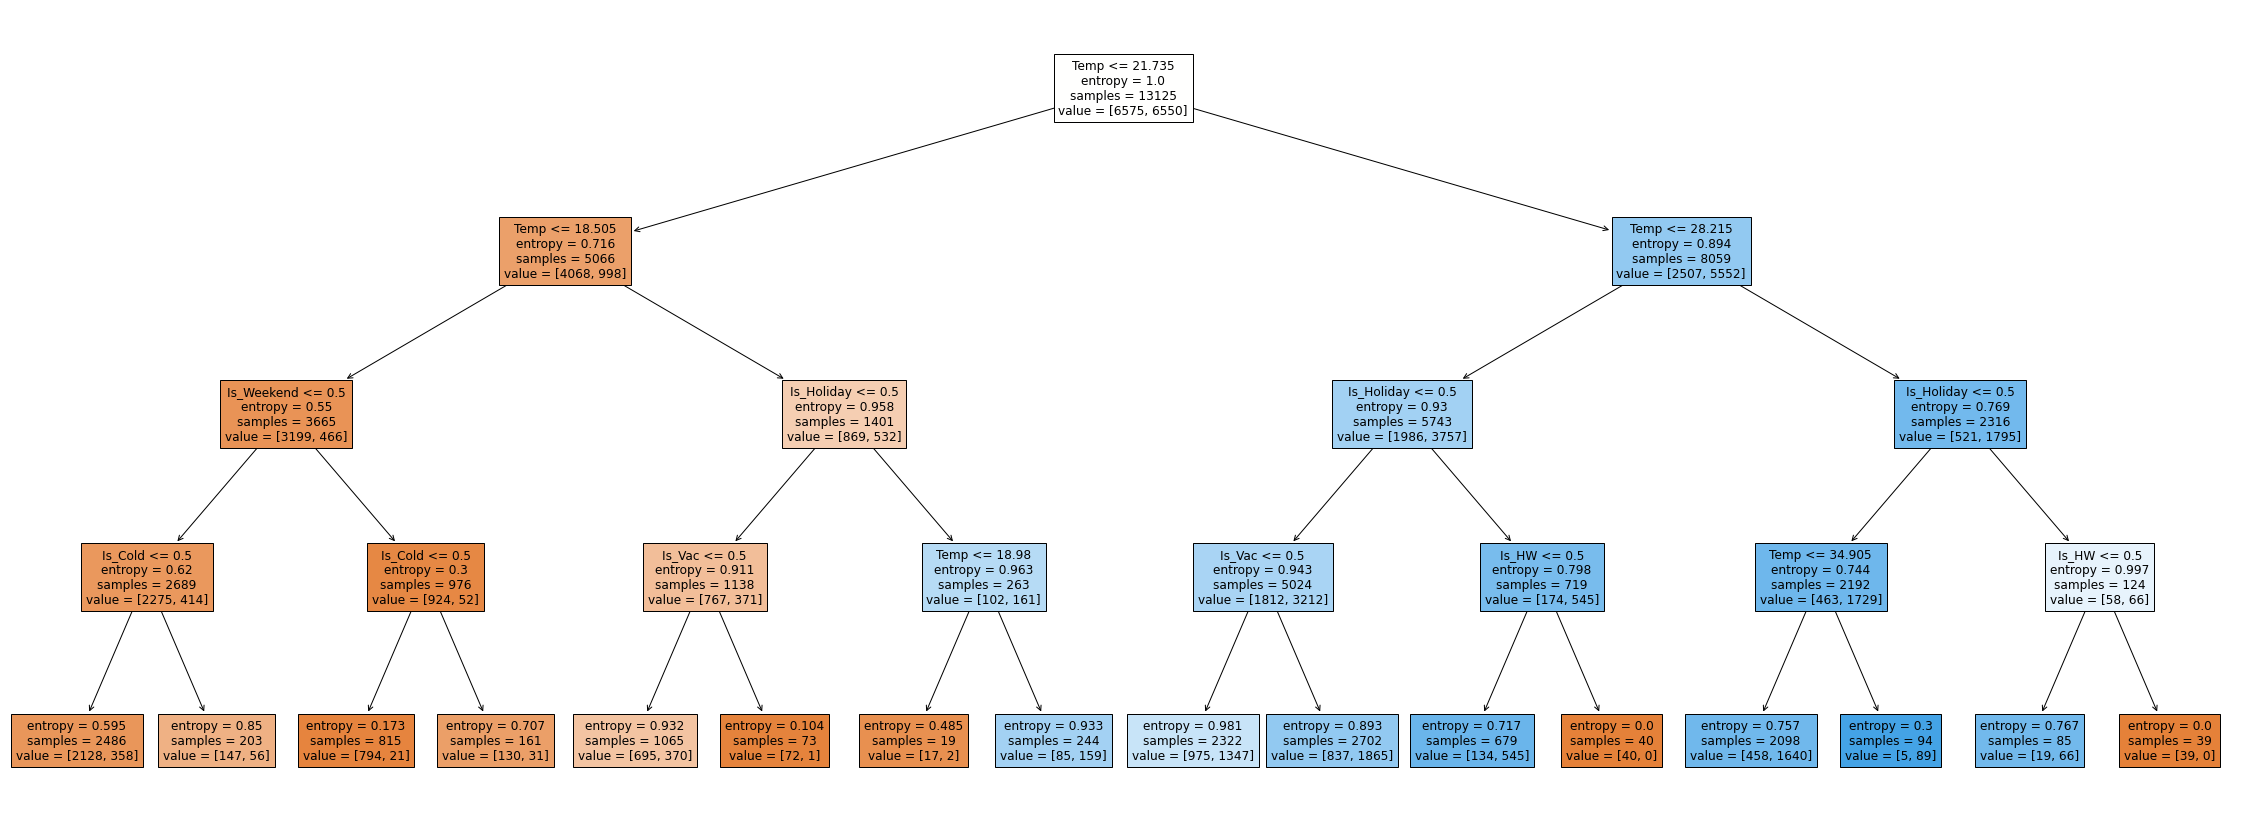

In [13]:
from sklearn import tree
features = list(X.columns)

fig = plt.figure(figsize=(40,15))
tree_img = tree.plot_tree(dtree,
                   feature_names=features,  
                   filled=True)
fig.show() # הצגת עץ החלטה גזום

In [14]:
fig = go.Figure()
trace = go.Bar(
    x = dtree.feature_importances_,
    y = features,
    orientation='h'
)
fig.add_trace(trace)
# בעזרת הגרף ניתן לראות שפיצר הטמפרטורה הוא המשפיע ביותר

##חיזוי והערכת המודל

In [15]:
y_pred = dtree.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
pred_df = pd.DataFrame({"Actual": df_balanced.SMP_Above_190, "Prediction":y_pred} ,index = y_test.index)
pred_df.head()
# כל שורה מסט המבחן הוא יבדוק על העץ ונראה כמה פעמים צדק

,Actual,Prediction
9878,1,1
15010,1,1
9630,1,1
16150,1,1
13141,1,1


In [16]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred_df))
print(classification_report(y_test,y_pred_df))
# ניתן לראות שהמודל שלנו חזק יותר בחיזוי של 1 מאשר חיזוי של 0

[[1723 1077]
 [ 355 2470]]
              precision    recall  f1-score   support

           0       0.83      0.62      0.71      2800
           1       0.70      0.87      0.78      2825

    accuracy                           0.75      5625
   macro avg       0.76      0.74      0.74      5625
weighted avg       0.76      0.75      0.74      5625



# מודל יערות רנדומיים

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,criterion='entropy') 

In [18]:
rfc.fit(X_train,y_train) # אימון המודל
y_predict = rfc.predict(X_test) # בוחנים את המודל

###הערכת המודל

In [19]:
print(confusion_matrix(y_test,y_predict))
print('----------------------------------------------------------')
print(classification_report(y_test,y_predict))

# ניתן לראות שהמודל שלנו חזק יותר בחיזוי של 1 מאשר חיזוי של 0

[[2061  739]
 [ 378 2447]]
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      2800
           1       0.77      0.87      0.81      2825

    accuracy                           0.80      5625
   macro avg       0.81      0.80      0.80      5625
weighted avg       0.81      0.80      0.80      5625



##Cross Validation

In [20]:
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
auc_scores

array([0.88748797, 0.86399854, 0.86574844, 0.87870773, 0.86038097,
       0.86796768, 0.87433753, 0.87298585, 0.86765877, 0.86518922])

In [21]:
accuracy_scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
accuracy_scores

array([0.8256    , 0.8096    , 0.79733333, 0.8224    , 0.79946667,
       0.81493333, 0.8096    , 0.81226667, 0.81813333, 0.81013333])

In [22]:
print('Mean values')
print('auc:', auc_scores.mean())
print('accuracy: ', accuracy_scores.mean())

Mean values
auc: 0.870446270704717
accuracy:  0.8119466666666666


#מודל עצי החלטה ללא פיצר של גלי חום

In [23]:
without_HM = df_balanced.drop('Is_HW',axis=1)
without_HM

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,SMP_Above_190
0,13.36,0,0,0,0,0
1,18.04,0,0,0,0,0
2,16.73,0,0,1,0,0
3,25.04,0,0,0,0,0
4,13.87,1,0,0,0,0
...,...,...,...,...,...,...
18745,26.26,0,1,1,0,1
18746,25.67,1,0,0,0,1
18747,23.03,0,0,0,0,1
18748,30.17,0,1,0,0,1


In [24]:
X = without_HM.drop('SMP_Above_190',axis=1)
y = without_HM['SMP_Above_190']
X

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold
0,13.36,0,0,0,0
1,18.04,0,0,0,0
2,16.73,0,0,1,0
3,25.04,0,0,0,0
4,13.87,1,0,0,0
...,...,...,...,...,...
18745,26.26,0,1,1,0
18746,25.67,1,0,0,0
18747,23.03,0,0,0,0
18748,30.17,0,1,0,0


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [26]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="entropy",max_depth=4) # מקסימום גובה, שלבים של העץ
dtree.fit(X_train,y_train) # אימון של סט האימון

DecisionTreeClassifier(criterion='entropy', max_depth=4)

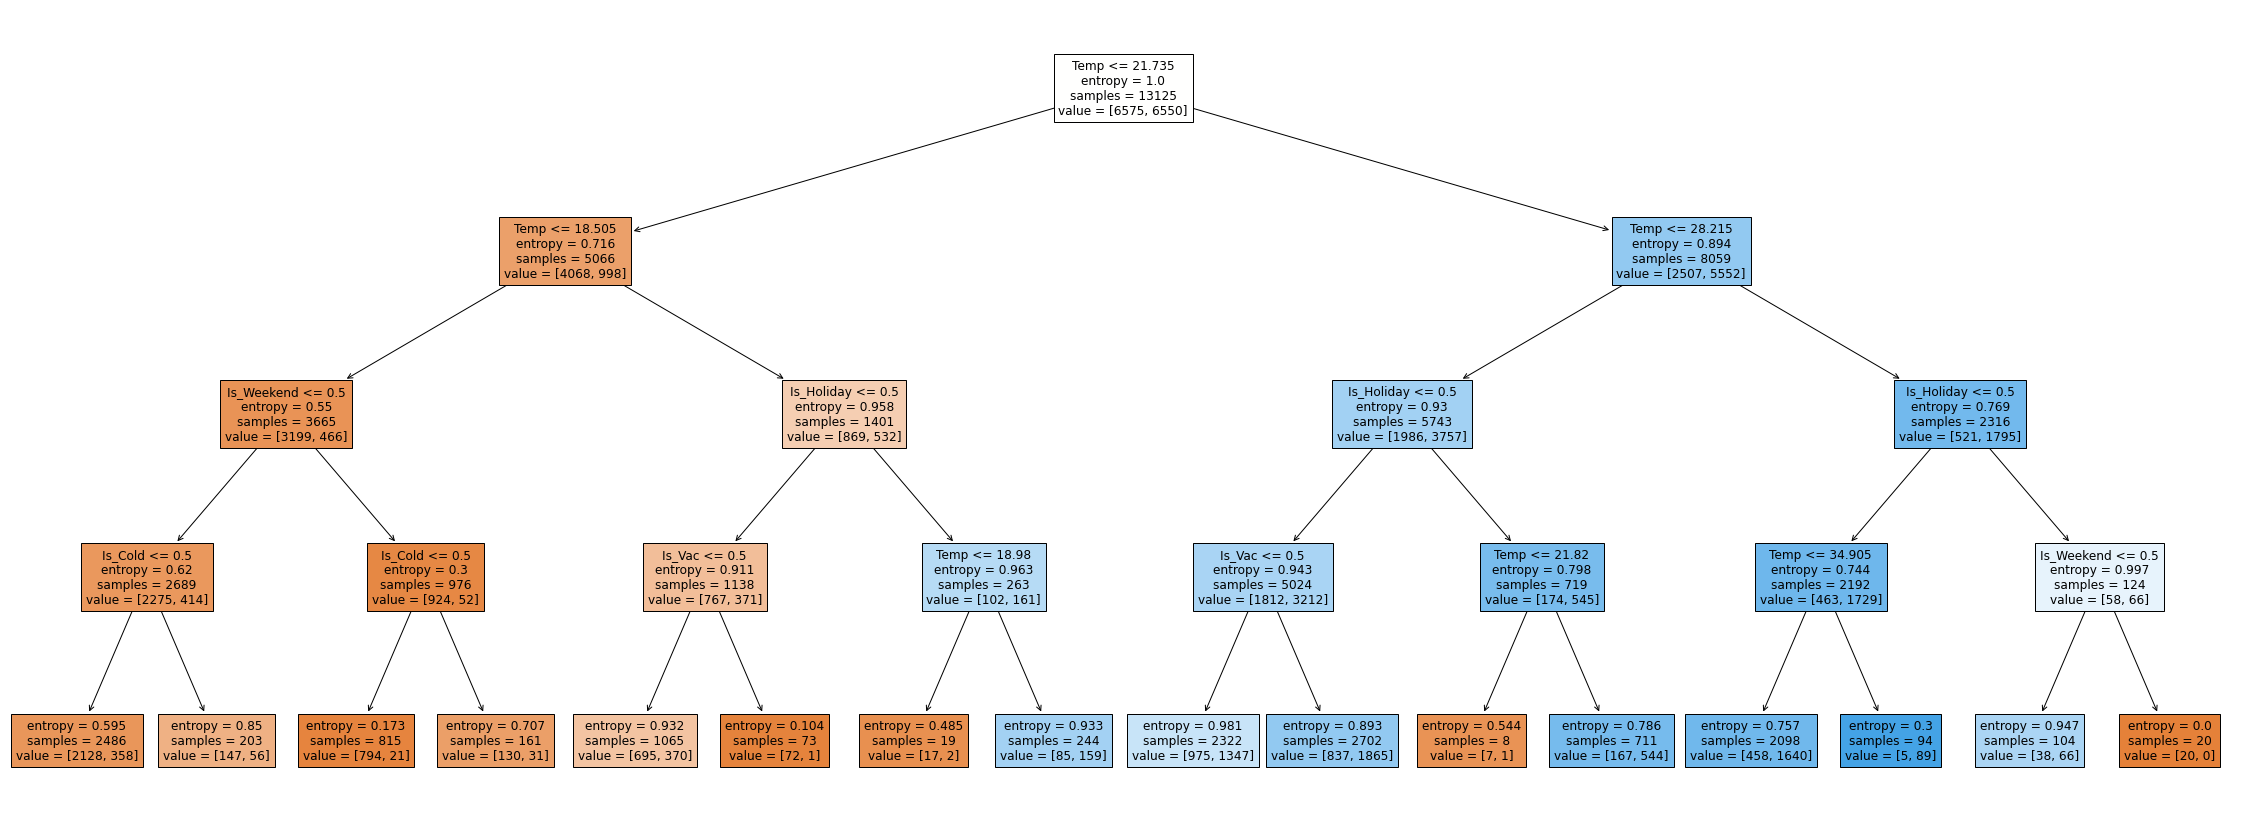

In [27]:
from sklearn import tree
features = list(X.columns)

fig = plt.figure(figsize=(40,15))
tree_img = tree.plot_tree(dtree,
                   feature_names=features,  
                   filled=True)
fig.show()

In [28]:
fig = go.Figure()
trace = go.Bar(
    x = dtree.feature_importances_,
    y = features,
    orientation='h'
)
fig.add_trace(trace)

###חיזוי והערכת המודל

In [29]:
y_pred = dtree.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
pred_df = pd.DataFrame({"Actual": without_HM.SMP_Above_190, "Prediction":y_pred} ,index = y_test.index)
pred_df.head()
# כל שורה מסט המבחן הוא יבדוק על העץ ונראה כמה פעמים צדק

,Actual,Prediction
9878,1,1
15010,1,1
9630,1,1
16150,1,1
13141,1,1


In [30]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred_df))
print(classification_report(y_test,y_pred_df))
# מודל חוזה טוב יותר 1

[[1702 1098]
 [ 356 2469]]
              precision    recall  f1-score   support

           0       0.83      0.61      0.70      2800
           1       0.69      0.87      0.77      2825

    accuracy                           0.74      5625
   macro avg       0.76      0.74      0.74      5625
weighted avg       0.76      0.74      0.74      5625



##יערות רנדומיים

In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,criterion='entropy') # שלושים עצים

In [32]:
rfc.fit(X_train,y_train) # אימון המודל
y_predict = rfc.predict(X_test) # בוחנים את המודל

###הערכת המודל

In [33]:
print(confusion_matrix(y_test,y_predict))
print('----------------------------------------------------------')
print(classification_report(y_test,y_predict))
# ניתן לראות שהמודל שלנו חזק יותר בחיזוי של 1 מאשר חיזוי של 0
# ניתן לראות שהמדדים עדיין גבוים, מה שמצביע שגלי חום אינם משפיעים משמעותית על המודל

[[1996  804]
 [ 402 2423]]
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.71      0.77      2800
           1       0.75      0.86      0.80      2825

    accuracy                           0.79      5625
   macro avg       0.79      0.79      0.78      5625
weighted avg       0.79      0.79      0.78      5625



###Cross Validation

In [34]:
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
auc_scores

array([0.87401554, 0.8488695 , 0.85618826, 0.86500604, 0.84237165,
       0.85703477, 0.84616045, 0.86170819, 0.85135327, 0.85726403])

In [35]:
accuracy_scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
accuracy_scores

array([0.8096    , 0.792     , 0.79466667, 0.80746667, 0.7824    ,
       0.79946667, 0.78453333, 0.80746667, 0.80106667, 0.80106667])

In [36]:
print('Mean values')
print('auc:', auc_scores.mean())
print('accuracy: ', accuracy_scores.mean())

Mean values
auc: 0.8559971714836399
accuracy:  0.7979733333333332


#מודל עצי החלטה ללא פיצר של טמפרטורה

In [37]:
without_Temp = df_balanced.drop('Temp',axis=1)
without_Temp

,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
18745,0,1,1,0,1,1
18746,1,0,0,0,0,1
18747,0,0,0,0,0,1
18748,0,1,0,0,0,1


In [38]:
X = without_Temp.drop('SMP_Above_190',axis=1)
y = without_Temp['SMP_Above_190']
X

,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,1,0,0
3,0,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
18745,0,1,1,0,1
18746,1,0,0,0,0
18747,0,0,0,0,0
18748,0,1,0,0,0


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [40]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="entropy",max_depth=4) # מקסימום גובה, שלבים של העץ
dtree.fit(X_train,y_train) # אימון של סט האימון

DecisionTreeClassifier(criterion='entropy', max_depth=4)

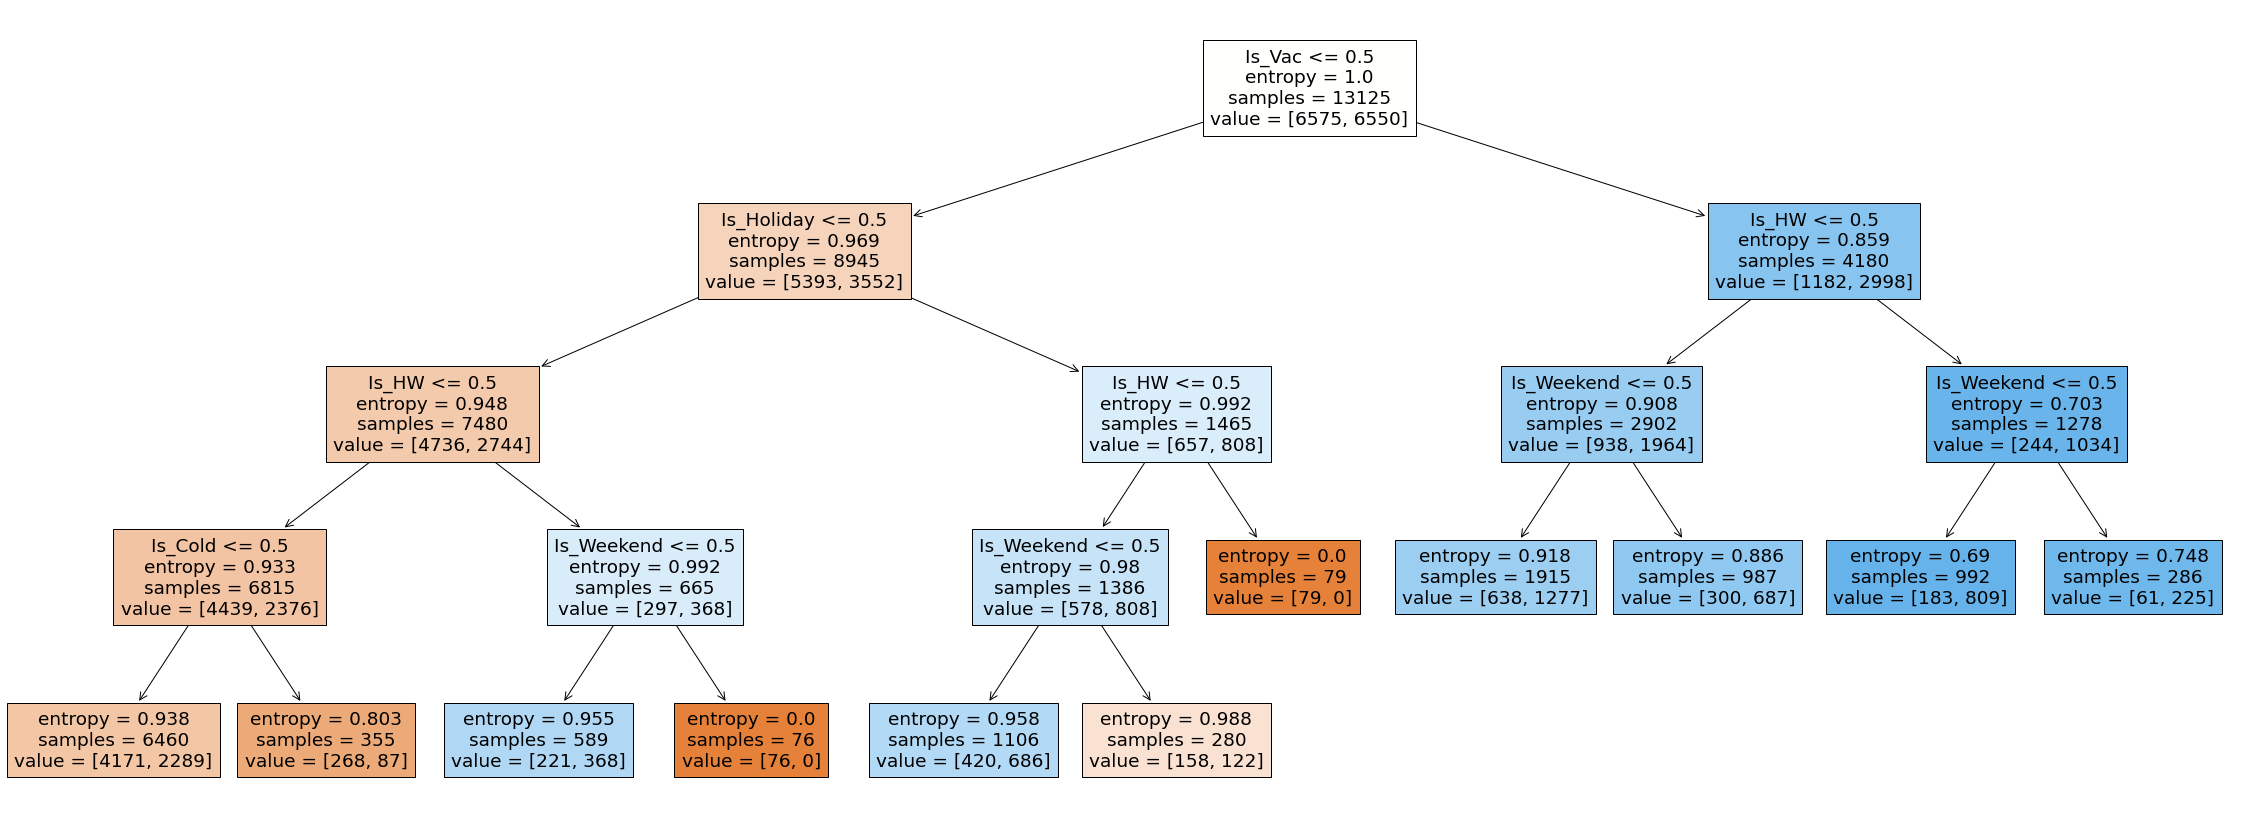

In [41]:
from sklearn import tree
features = list(X.columns)

fig = plt.figure(figsize=(40,15))
tree_img = tree.plot_tree(dtree,
                   feature_names=features,  
                   filled=True)
fig.show()

In [42]:
fig = go.Figure()
trace = go.Bar(
    x = dtree.feature_importances_,
    y = features,
    orientation='h'
)
fig.add_trace(trace)
# כאשר הסרנו את פיצר הטמפרטורה, הפיצר של האם חופשה נהפך למשמעותי ביותר

###חיזוי והערכת המודל

In [43]:
y_pred = dtree.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
pred_df = pd.DataFrame({"Actual": without_HM.SMP_Above_190, "Prediction":y_pred} ,index = y_test.index)
pred_df.head()
# כל שורה מסט המבחן הוא יבדוק על העץ ונראה כמה פעמים צדק

,Actual,Prediction
9878,1,1
15010,1,1
9630,1,1
16150,1,1
13141,1,1


In [44]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred_df))
print(classification_report(y_test,y_pred_df))
# ניתן לראות שחזק יותר בחיזוי של 0

[[1993  807]
 [1095 1730]]
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      2800
           1       0.68      0.61      0.65      2825

    accuracy                           0.66      5625
   macro avg       0.66      0.66      0.66      5625
weighted avg       0.66      0.66      0.66      5625



##יערות רנדומיים

In [45]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,criterion='entropy') # שלושים עצים

In [46]:
rfc.fit(X_train,y_train) # אימון המודל
y_predict = rfc.predict(X_test) # בוחנים את המודל

###הערכת המודל

In [47]:
print(confusion_matrix(y_test,y_predict))
print('----------------------------------------------------------')
print(classification_report(y_test,y_predict))

# ניתן לראות שחזק יותר בחיזוי של 0

[[2001  799]
 [1095 1730]]
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      2800
           1       0.68      0.61      0.65      2825

    accuracy                           0.66      5625
   macro avg       0.67      0.66      0.66      5625
weighted avg       0.67      0.66      0.66      5625



###Cross Validation

In [48]:
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
auc_scores

array([0.7221745 , 0.66514792, 0.69201371, 0.70639522, 0.68636009,
       0.70569833, 0.68861004, 0.69965389, 0.69154039, 0.68578324])

In [49]:
accuracy_scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
accuracy_scores

array([0.70026667, 0.64746667, 0.672     , 0.67733333, 0.6592    ,
       0.67733333, 0.6624    , 0.67146667, 0.66506667, 0.6576    ])

In [50]:
print('Mean values')
print('auc:', auc_scores.mean())
print('accuracy: ', accuracy_scores.mean())
# מאחר ופיצר הטמפרטורה הוא המשמעותי ביותר, לאחר הסרתו רמת הדיוק ירדה משמעותית

Mean values
auc: 0.6943377335005109
accuracy:  0.6690133333333333
